In [1]:
import os 
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting the device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
PYTORCH_ENABLE_MPS_FALLBACK=1
print("You are using device: %s" % device)

You are using device: cpu


In [3]:
# setting up data for pytorch

class CensusData(torch.utils.data.Dataset):
    
    def __init__(self, ind_vars, dep_var):
        
        self.ind_vars = ind_vars
        self.dep_var = dep_var
        
    def __len__(self):
        return len(self.dep_var)
    
    def __getitem__(self, idx):
        datapoint = self.ind_vars[idx]
        response = self.dep_var[idx]
        
        return datapoint, response
        

In [23]:
# load in the data as df
pwd = os.getcwd()
#print(pwd)

data = pd.read_csv(pwd+'/data/normalized_percents.csv')

# change all column names to lowercase
data.columns = data.columns.str.lower()

# drop 2001 since income 0 and also drop rows where income is 0
data = data[data['year'] != 2001]
data = data[data['total annual income (£)'] != 0]

#zero = set(data[data['year'] == 2001]['msoa code'].tolist())
one = set(data[data['year'] == 2011]['msoa code'].tolist())
two = set(data[data['year'] == 2021]['msoa code'].tolist())

common_index = one.intersection(two)
mask = data['msoa code'].isin(common_index)
data = data[mask]

# creating summed column of higher occupation for pca score later
occ_pat = '(^occupation:\smanager.*)|(^occupation.*professional.*)'
    
occ_match = re.compile(occ_pat)
co = [c for c in data.columns.tolist() if occ_match.match(c)]

data['higher_occupation'] = data[co].sum(axis=1)

#print(len(data))

# check the column names 
#cols = data.columns.tolist()
#cols # doesn't look like SES score is there
#print(len(data)) 9779 rows in original data

# load the ses scores
#ses_data = pd.read_csv(pwd+'/data/scores.csv')

In [24]:
# dropping the separate higher occupation percent columns
data.drop(co, axis=1, inplace=True)
#print(data.columns.tolist())

['msoa code', 'msoa name', 'city code', 'city name', 'year', 'age: 0 to 4', 'age: 10 to 14', 'age: 15 to 19', 'age: 16 years and over', 'age: 20 to 24', 'age: 25 to 29', 'age: 30 to 44', 'age: 45 to 59', 'age: 5 to 9', 'age: 60 to 64', 'age: 65 to 74', 'age: 75 to 84', 'age: 85 years and over', 'disabled under the equality act: day-to-day activities limited a little', 'disabled under the equality act: day-to-day activities limited a lot', 'economic activity: economically active', 'economic activity: economically active: employee: full-time', 'economic activity: economically active: employee: part-time', 'economic activity: economically active: full-time student', 'economic activity: economically active: in employment', 'economic activity: economically active: self-employed', 'economic activity: economically active: unemployed', 'economic activity: economically inactive', 'economic activity: economically inactive: long-term sick or disabled', 'economic activity: economically inactive: l

# Experiment 1
Scaling data using all years and all cities in one. Train on change between 2001 and 2011. Then test on 2021. Include the PCA variables in the training data.

### Results
- Valid Accuracy: 0.7254901960784313
- Valid Balanced Accuracy: 0.5689948346113125

A little worse on test. Predicting SD change instead gives balance accuracy = 0.5 on Training.

In [25]:
# scaling - log transform on income and then scaling introduces 82 rows == 0

# set pincode to index
exp1_data = data.set_index('msoa code')
#print(exp1_data.year)

# turn the year column into a string
exp1_data['year'] = exp1_data['year'].astype(str)

# get log of income and house price
exp1_data['median house price'] = np.log(exp1_data['median house price'])
exp1_data['total annual income (£)'] = np.log(exp1_data['total annual income (£)'])

# get the non-numeric cols
exp1_nonnumeric = exp1_data.select_dtypes(include='object') # has 9779 rows

# get numeric columns only NEED TO EXCLUDE YEAR
exp1_numeric = exp1_data.select_dtypes(include='number')
#print(len(exp1_numeric.columns))
scaler = preprocessing.RobustScaler().fit(exp1_numeric)
exp1_scaled = scaler.transform(exp1_numeric) # still maintains 9779 rows
exp1_numeric = pd.DataFrame(exp1_scaled, index=exp1_numeric.index, columns=exp1_numeric.columns) # 9779 rows
exp1_numeric['year'] = exp1_nonnumeric['year']
#print(exp1_numeric['year'].head())

# merge back into single df
exp1_processed = exp1_nonnumeric.merge(exp1_numeric, how='inner', on=['msoa code', 'year'])

#print(len(exp1_processed))

In [30]:
# creating the df of variables to create ses score

pattern = '(year)|(.*level 4.*)|(.*price.*)|(.*income.*)|(higher_occupation)'
    
m = re.compile(pattern)
cols = [c for c in data.columns.tolist() if m.match(c)]
#print(cols)

ses_vars = exp1_processed[cols]

ses_vars.sort_values(by=['year','msoa code'], ascending=True, inplace=True)
#print(ses_vars.head())


print(ses_vars.head())

           year  \
msoa code         
E02000001  2011   
E02000002  2011   
E02000003  2011   
E02000004  2011   
E02000005  2011   

           highest level of qualification: level 4 qualifications or above  \
msoa code                                                                    
E02000001                                           2.079763                 
E02000002                                          -0.578862                 
E02000003                                          -0.300022                 
E02000004                                          -0.595959                 
E02000005                                          -0.610861                 

           median house price  total annual income (£)  higher_occupation  
msoa code                                                                  
E02000001            1.047336                 1.408548           1.843460  
E02000002           -0.047193                -0.340952          -0.495484  
E02000003      

/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_68274/3307025896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ses_vars.sort_values(by=['year','msoa code'], ascending=True, inplace=True)


### Checking how many zeros there are in total annual income
34.1% of the rows have total annual income of 0.0. 3259 rows in 2001 have 0 income.

In [7]:
perc_0_income = len(ses_vars[ses_vars['total annual income (£)'] == 0.0]) / len(ses_vars)
zero_income = ses_vars[ses_vars['total annual income (£)'] == 0.0]

zero_income.groupby('year').count()

,highest level of qualification: level 4 qualifications or above,median house price,total annual income (£),occupation
year,,,,
2011,82,82,82,82


### PCA and Results
79% of the variance is explained by the 1st principal component. 2nd feature is most important, then 1st, 4th, and 3rd. Corresponding to House Price (2nd), Qualification (1st), Occupation (4th), and Income (3rd)

In [31]:
# pca for ses score
ses_np_scaled = ses_vars.drop('year', axis=1).to_numpy()

pca = decomposition.PCA(n_components=1, random_state=16)
pca.fit(ses_np_scaled)

first_comp = pca.transform(ses_np_scaled)

num_msoa_year = len(ses_vars) // 2
#print(type(num_msoa_year))

scores11 = first_comp[ :num_msoa_year]
scores21 = first_comp[num_msoa_year: ]
#scores21 = first_comp[2*num_msoa_year: ]

assert len(scores11) + len(scores21) == len(ses_vars), 'scores and ses_vars differ in num rows'

# change from np arrays to df and add the index
#ses_vars01 = ses_vars[ses_vars['year'] == 2001]
ses_vars11 = ses_vars[ses_vars['year'] == '2011']
ses_vars21 = ses_vars[ses_vars['year'] == '2021']

#scores01 = pd.DataFrame(scores01, index=ses_vars01.index)
#scores01 = scores01.rename(columns={0: 'ses_score'})
scores11 = pd.DataFrame(scores11, index=ses_vars11.index)
scores11 = scores11.rename(columns={0: 'ses_score'})
scores21 = pd.DataFrame(scores21, index=ses_vars21.index)
scores21 = scores21.rename(columns={0: 'ses_score'})

scores_combined = scores11.merge(scores21, how='inner',on='msoa code',suffixes=['_11', '_21'])
#scores_combined = scores_combined.rename(columns={'ses_score':'ses_score_21'})
print(scores_combined.head())

           ses_score_11  ses_score_21
msoa code                            
E02000001      3.060824      3.849733
E02000002     -0.892658     -0.029974
E02000003     -0.298174      0.389150
E02000004     -0.590434      0.403378
E02000005     -0.878350      0.196340


In [32]:
pca.components_

array([[0.53179603, 0.48547477, 0.48680423, 0.4944986 ]])

### Density of SES Scores by Year
The distributions are right skewed

/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_68274/1643501140.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores_combined['ses_score_11'], shade=True, ax=axes[0])
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_68274/1643501140.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores_combined['ses_score_21'], shade=True, ax=axes[1])


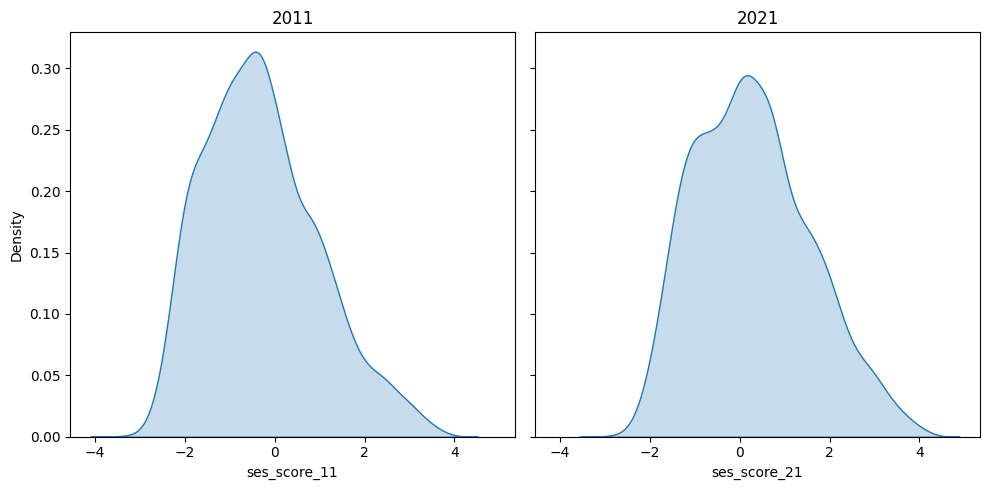

In [33]:
# look at the density of scores each year
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
#sns.kdeplot(scores_combined['ses_score_01'], shade=True, ax=axes[0])
#axes[0].set_title("2001")

sns.kdeplot(scores_combined['ses_score_11'], shade=True, ax=axes[0])
axes[0].set_title("2011")

sns.kdeplot(scores_combined['ses_score_21'], shade=True, ax=axes[1])
axes[1].set_title("2021")

plt.tight_layout()
plt.show()

### Processing the data for modeling

In [34]:
# takes into account negatives and gives correct change
#scores_combined['ses_diff_01_11'] = scores_combined['ses_score_11'] - scores_combined['ses_score_01']
scores_combined['ses_diff_11_21'] = scores_combined['ses_score_21'] - scores_combined['ses_score_11']

In [40]:
# combine processed data and score 
#dep_01_11 = pd.DataFrame(scores_combined['score_sd_01_11'])
#y = pd.DataFrame(['2001']*len(dep_01_11), index=dep_01_11.index)
#dep_01_11 = dep_01_11.merge(y, how='inner', on='msoa code')
#dep_01_11.rename(columns={'score_sd_01_11': 'y_var', 0: 'year'}, inplace=True)

dep_11_21 = pd.DataFrame(scores_combined['ses_diff_11_21'])
y = pd.DataFrame(['2011']*len(dep_11_21), index=dep_11_21.index)
dep_11_21 = dep_11_21.merge(y, how='inner', on='msoa code')
dep_11_21.rename(columns={'ses_diff_11_21': 'y_var', 0: 'year'}, inplace=True)

#dep_df = pd.concat((dep_01_11, dep_11_21))

# drop 2021 rows in exp1
data_processed = exp1_processed[exp1_processed['year'] != '2021']

# combine dependent and ind vars
data_processed = data_processed.merge(dep_11_21, how='inner', on=['msoa code', 'year'])


In [42]:
# get 2011 data and do train test split
#data_proc_2001 = data_processed[data_processed['year'] == '2001']

# get the data ready for modeling

# drop the year column
data_processed = data_processed.drop(['year', 'msoa name', 'city code', 'city name'], axis=1)
X = data_processed.loc[:, data_processed.columns != 'y_var'].to_numpy()
y = data_processed['y_var'].to_numpy()

# split data into training and testing 
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.2, random_state=386)

X_train, X_valid, y_train, y_valid = train_test_split(X_t, y_t, test_size=0.2, random_state=440)

In [43]:
# init the pytorch dataset class
dataset_params = {'batch_size': 64,
                 'shuffle': True}


training_data_2011 = CensusData(X_train, y_train)
training_loader_2011 = torch.utils.data.DataLoader(training_data_2011, **dataset_params)

valid_data_2011 = CensusData(X_valid, y_valid)
valid_loader_2011 = torch.utils.data.DataLoader(valid_data_2011, **dataset_params)


### Setting up Optuna Trials and Getting Best Model

In [75]:
# set up hyperparameters in optuna trial
def define_model(trial):
    
    n_layers = trial.suggest_int("n_layers", 1, 4)
    layers = []
    
    in_features = X_train.shape[1]

    for l in range(n_layers):
        out_features = trial.suggest_int(name="n_units_l{}".format(l), low=10, high=160, step=5)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.Tanh())
        p = trial.suggest_float(name="dropout_l{}".format(l), low=0.2, high=0.5, step=0.1)
        layers.append(nn.Dropout(p))
        
        in_features = out_features
    
    layers.append(nn.Linear(in_features, 1))
    
    return nn.Sequential(*layers)

In [45]:
# running optuna where objective is a class so I can get the best model
mse_loss = nn.MSELoss()
EPOCHS = 100

class Objective:
    
    def __init__(self, train_data_loader, valid_data_loader, defined_model):
        
        self.best_booster = None
        self._booster = None
        self.train_loader = train_data_loader
        self.valid_loader = valid_data_loader
        self.define_model = defined_model
        
    def __call__(self, trial):
        
        model = self.define_model(trial).to(device)
    
        lr = trial.suggest_float(name="lr", low=1e-5, high=1e-1, log=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(EPOCHS):
        
            model.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.view(data.size(0), -1).to(device), target.to(device)
        
                optimizer.zero_grad() # reset gradients so they don't accumulate
                output = model(data.float())
                loss = mse_loss(output, target.float())
                loss.backward()
                optimizer.step()
    
            epoch_mse = 0.0
            model.eval()
            with torch.no_grad(): # don't store gradients
                for b_idx, (d, t) in enumerate(self.valid_loader):
                    d, t = d.view(d.size(0), -1).to(device), t.to(device)
                    pred = model(d.float())
        
                    valid_loss = mse_loss(pred, target.float())
                    epoch_mse += valid_loss
    
            trial.report(epoch_mse, epoch)
        
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
                
        self._booster = model
        
        return epoch_mse
    
    def callback(self, study, trial):
        
        if study.best_trial == trial:
            self.best_booster = self._booster

### Running optuna trial to predict change in SES score

In [76]:
# running optuna trial using class objective

obj = Objective(training_loader_2011, valid_loader_2011, define_model)
cls_sampler = TPESampler(seed=440)
cls_study = optuna.create_study(direction='minimize', sampler=cls_sampler)
cls_study.optimize(obj, n_trials=150, timeout=600, callbacks=[obj.callback])

print("Best Trial:")
cls_trial = cls_study.best_trial

print("  Params: ")
for key, value in cls_trial.params.items():
    print("    {}: {}".format(key, value))

best_model = obj.best_booster
print("Best Model")
best_model

[I 2024-04-14 23:30:47,739] A new study created in memory with name: no-name-4b0d3b3f-31fb-495e-8412-a9558221d628
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([55])) that is different to the i

[I 2024-04-14 23:37:12,804] Trial 73 finished with value: 0.45339760184288025 and parameters: {'n_layers': 3, 'n_units_l0': 125, 'dropout_l0': 0.2, 'n_units_l1': 75, 'dropout_l1': 0.5, 'n_units_l2': 105, 'dropout_l2': 0.5, 'lr': 0.002670873286049992}. Best is trial 2 with value: 0.37573206424713135.
[I 2024-04-14 23:37:13,089] Trial 74 pruned. 
[I 2024-04-14 23:37:13,230] Trial 75 pruned. 
[I 2024-04-14 23:37:13,366] Trial 76 pruned. 
[I 2024-04-14 23:37:13,500] Trial 77 pruned. 
[I 2024-04-14 23:37:13,672] Trial 78 pruned. 
[I 2024-04-14 23:37:13,890] Trial 79 pruned. 
[I 2024-04-14 23:37:14,641] Trial 80 pruned. 
[I 2024-04-14 23:37:14,947] Trial 81 pruned. 
[I 2024-04-14 23:37:15,100] Trial 82 pruned. 
[I 2024-04-14 23:37:15,954] Trial 83 pruned. 
[I 2024-04-14 23:37:16,134] Trial 84 pruned. 
[I 2024-04-14 23:38:09,245] Trial 85 finished with value: 0.48564592003822327 and parameters: {'n_layers': 4, 'n_units_l0': 85, 'dropout_l0': 0.4, 'n_units_l1': 35, 'dropout_l1': 0.5, 'n_units_

Best Trial:
  Params: 
    n_layers: 4
    n_units_l0: 155
    dropout_l0: 0.4
    n_units_l1: 55
    dropout_l1: 0.5
    n_units_l2: 85
    dropout_l2: 0.5
    n_units_l3: 125
    dropout_l3: 0.30000000000000004
    lr: 6.063036981951539e-05
Best Model


Sequential(
  (0): Linear(in_features=209, out_features=155, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=155, out_features=55, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=55, out_features=85, bias=True)
  (7): Tanh()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=85, out_features=125, bias=True)
  (10): Tanh()
  (11): Dropout(p=0.30000000000000004, inplace=False)
  (12): Linear(in_features=125, out_features=1, bias=True)
)

### Exp 1 Metric Results on Train, Valid, Test

In [50]:
def change_metrics(y_true, y_pred, dataset='Valid'):
    
    # should only pass in numpy arrays
    
    # calculate how many sd away each is for true
    true_mean, true_sd = np.mean(y_true), np.std(y_true)
    true_sd_change = (y_true - true_mean) / true_sd
    
    # for pred calculate how much change
    pred_mean, pred_sd = np.mean(y_pred), np.std(y_pred)
    pred_sd_change = (y_pred - pred_mean) / pred_sd
    
    true_sd_change_cls = true_sd_change >= 1.0
    true_sd_change_cls = true_sd_change_cls.astype(int)
    
    pred_sd_change_cls = pred_sd_change >= 1.0
    pred_sd_change_cls = pred_sd_change_cls.astype(int)
    
    y_acc = accuracy_score(true_sd_change_cls, pred_sd_change_cls)
    y_bacc = balanced_accuracy_score(true_sd_change_cls, pred_sd_change_cls)
    y_f1 = f1_score(true_sd_change_cls, pred_sd_change_cls)

    print(f'{dataset} Accuracy: {y_acc}')
    print(f'{dataset} Balanced Accuracy: {y_bacc}')
    print(f'{dataset} F1: {y_f1}')

In [73]:
# get performance metrics on 2011 - 2021 validation set
with torch.no_grad():
    y_valid_pred = best_model(torch.from_numpy(X_valid).float())
    #mse_loss_valid = mse_loss(y_valid_pred, y_valid)

change_metrics(y_valid, y_valid_pred.numpy())

Valid Accuracy: 0.8568627450980392
Valid Balanced Accuracy: 0.5036253970290995
Valid F1: 0.02666666666666667


In [69]:
# train set performance
with torch.no_grad():
    y_train_pred = best_model(torch.from_numpy(X_train).float())
    #mse_loss_valid = mse_loss(y_valid_pred, y_valid)

change_metrics(y_train, y_train_pred.numpy(), dataset='Train')

Train Accuracy: 0.8410985777341834
Train Balanced Accuracy: 0.5536473721038719
Train F1: 0.21359223300970873


In [74]:
with torch.no_grad():
    y_test_pred = best_model(torch.from_numpy(X_test).float())

change_metrics(y_test, y_test_pred.numpy(), dataset='Test')

Test Accuracy: 0.8605015673981191
Test Balanced Accuracy: 0.4990909090909091
Test F1: 0.0


## Experiment 1.1
Predicting SD change instead of SES Score diff

In [63]:
def sd_metrics(y_true, y_pred, continuous=True, data='Valid'):
    
    if continuous:
        y_true_class = y_true >= 1
        y_true_class = y_true_class.astype(int)

        y_pred_class = y_pred.numpy() >= 1
        y_pred_class = y_pred_class.astype(int)

        y_acc = accuracy_score(y_true_class, y_pred_class)
        y_bacc = balanced_accuracy_score(y_true_class, y_pred_class)
        y_f1 = f1_score(y_true_class, y_pred_class)

        print(f'{data} Accuracy: {y_acc}')
        print(f'{data} Balanced Accuracy: {y_bacc}')
        print(f'{data} F1: {y_f1}')
    
    else:
        y_acc = accuracy_score(y_true, y_pred)
        y_bacc = balanced_accuracy_score(y_true, y_pred)
        y_f1 = f1_score(y_true, y_pred)

        print(f'{data} Accuracy: {y_acc}')
        print(f'{data} Balanced Accuracy: {y_bacc}')
        print(f'{data} F1: {y_f1}')

In [57]:
# create the sd y_var and process dataset for torch loaders
depsd_11_21 = pd.DataFrame(scores_combined['ses_diff_11_21'])

# adding year as a col
y = pd.DataFrame(['2011']*len(depsd_11_21), index=depsd_11_21.index)
depsd_11_21 = depsd_11_21.merge(y, how='inner', on='msoa code')

# creating diff sd y_var col
avg_diff = np.mean(depsd_11_21['ses_diff_11_21'].to_numpy())
sd_diff = np.std(depsd_11_21['ses_diff_11_21'].to_numpy())
depsd_11_21['y_var'] = (depsd_11_21['ses_diff_11_21'] - avg_diff) / sd_diff

depsd_11_21.rename(columns={0: 'year'}, inplace=True)

# dropping diff col
depsd_11_21.drop('ses_diff_11_21', axis=1, inplace=True)

# drop 2021 rows in exp1
data_sd = exp1_processed[exp1_processed['year'] != '2021']

# combine dependent and ind vars
data_sd = data_sd.merge(depsd_11_21, how='inner', on=['msoa code', 'year'])

#print(data_sd.head())

                          msoa name  city code city name  year  age: 0 to 4  \
msoa code                                                                     
E02000001        City of London 001  J01000055    London  2011    -1.433765   
E02000002  Barking and Dagenham 001  J01000055    London  2011     1.515756   
E02000003  Barking and Dagenham 002  J01000055    London  2011     1.041116   
E02000004  Barking and Dagenham 003  J01000055    London  2011    -0.119592   
E02000005  Barking and Dagenham 004  J01000055    London  2011     1.529130   

           age: 10 to 14  age: 15 to 19  age: 16 years and over  \
msoa code                                                         
E02000001      -2.283827      -1.961457                0.166821   
E02000002       0.365815       0.299784               -0.758232   
E02000003       0.112180       0.140217                0.566879   
E02000004       0.376175       1.230088               -0.721177   
E02000005       0.880410       0.862159     

In [58]:
# train valid test split
data_sd = data_sd.drop(['year', 'msoa name', 'city code', 'city name'], axis=1)
X_sd = data_sd.loc[:, data_sd.columns != 'y_var'].to_numpy()
y_sd = data_sd['y_var'].to_numpy()

X_tt, X_test_sd, y_tt, y_test_sd = train_test_split(X_sd, y_sd, test_size=0.2, random_state=186)
X_train_sd, X_valid_sd, y_train_sd, y_valid_sd = train_test_split(X_sd, y_sd, test_size=0.2, random_state=186)

In [59]:
# init data and dataloader for new dataset

train_data_2011_sd = CensusData(X_train_sd, y_train_sd)
train_loader_2011_sd = torch.utils.data.DataLoader(train_data_2011_sd, **dataset_params)

valid_data_2011_sd = CensusData(X_valid_sd, y_valid_sd)
valid_loader_2011_sd = torch.utils.data.DataLoader(valid_data_2011_sd, **dataset_params)

In [60]:
obj1_1 = Objective(train_loader_2011_sd, valid_loader_2011_sd, define_model)
cls1_1_study = optuna.create_study(direction='minimize', sampler=cls_sampler)
cls1_1_study.optimize(obj1_1, n_trials=200, timeout=600, callbacks=[obj1_1.callback])

print("Best Trial:")
cls1_1_trial = cls1_1_study.best_trial

print("  Params: ")
for key, value in cls1_1_trial.params.items():
    print("    {}: {}".format(key, value))

best_model1_1 = obj1_1.best_booster
print("Best Model")
best_model1_1

[I 2024-04-14 21:42:48,609] A new study created in memory with name: no-name-0c76a241-6cd3-47db-aecb-a0a1e4c3a3f2
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([53])) that is different to the i

[I 2024-04-14 21:49:12,547] Trial 72 pruned. 
[I 2024-04-14 21:49:13,179] Trial 73 pruned. 
[I 2024-04-14 21:49:13,318] Trial 74 pruned. 
[I 2024-04-14 21:49:13,469] Trial 75 pruned. 
[I 2024-04-14 21:49:13,999] Trial 76 pruned. 
[I 2024-04-14 21:49:14,727] Trial 77 pruned. 
[I 2024-04-14 21:49:15,191] Trial 78 pruned. 
[I 2024-04-14 21:49:16,168] Trial 79 pruned. 
[I 2024-04-14 21:49:16,407] Trial 80 pruned. 
[I 2024-04-14 21:49:16,487] Trial 81 pruned. 
[I 2024-04-14 21:49:30,704] Trial 82 finished with value: 9.251827239990234 and parameters: {'n_layers': 1, 'n_units_l0': 70, 'dropout_l0': 0.30000000000000004, 'lr': 0.001045691009213554}. Best is trial 8 with value: 5.781948089599609.
[I 2024-04-14 21:49:43,604] Trial 83 finished with value: 10.0560302734375 and parameters: {'n_layers': 1, 'n_units_l0': 85, 'dropout_l0': 0.30000000000000004, 'lr': 0.0008516312714679563}. Best is trial 8 with value: 5.781948089599609.
[I 2024-04-14 21:49:43,728] Trial 84 pruned. 
[I 2024-04-14 21:49:

Best Trial:
  Params: 
    n_layers: 3
    n_units_l0: 95
    dropout_l0: 0.30000000000000004
    n_units_l1: 40
    dropout_l1: 0.5
    n_units_l2: 75
    dropout_l2: 0.5
    lr: 2.2161089993641e-05
Best Model


Sequential(
  (0): Linear(in_features=209, out_features=95, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.30000000000000004, inplace=False)
  (3): Linear(in_features=95, out_features=40, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=40, out_features=75, bias=True)
  (7): Tanh()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=75, out_features=1, bias=True)
)

In [65]:
# sd train metrics
with torch.no_grad():
    y_sd_train_pred = best_model1_1(torch.from_numpy(X_train_sd).float())

sd_metrics(y_train_sd, y_sd_train_pred, data='Train')

Train Accuracy: 0.8579835229501765
Train Balanced Accuracy: 0.5
Train F1: 0.0


# Experiment 2
Subsetting data to the 3 largets cities in England: London, Manchester, Birmingham

Need to redo scaling and creation of SES score

In [80]:
# scaling - log transform on income and then scaling introduces 82 rows == 0

# set pincode to index
exp2_data = data.set_index('msoa code')
#print(exp1_data.year)

# drop all cities except london, manchester, and birmingham
cities = ['Birmingham', 'Manchester', 'London']
mask = exp2_data['city name'].isin(cities)
exp2_data = exp2_data[mask]

# turn the year column into a string
exp2_data['year'] = exp2_data['year'].astype(str)

# get log of income and house price
exp2_data['median house price'] = np.log(exp2_data['median house price'])
exp2_data['total annual income (£)'] = np.log(exp2_data['total annual income (£)'])

# get the non-numeric cols
exp2_nonnumeric = exp2_data.select_dtypes(include='object') # has 9779 rows

# get numeric columns only NEED TO EXCLUDE YEAR
exp2_numeric = exp2_data.select_dtypes(include='number')
#print(len(exp1_numeric.columns))
scaler = preprocessing.RobustScaler().fit(exp2_numeric)
exp2_scaled = scaler.transform(exp2_numeric) # still maintains 9779 rows
exp2_numeric = pd.DataFrame(exp2_scaled, index=exp2_numeric.index, columns=exp2_numeric.columns) # 9779 rows
exp2_numeric['year'] = exp2_nonnumeric['year']
#print(exp1_numeric['year'].head())

# merge back into single df
exp2_processed = exp2_nonnumeric.merge(exp2_numeric, how='inner', on=['msoa code', 'year'])

#print(len(exp1_processed))

### Creating DF of Vars for SES Score

In [81]:
# creating the df of variables to create ses score

pattern = '(year)|(.*level 4.*)|(.*price.*)|(.*income.*)|(higher_occupation)'
    
m = re.compile(pattern)
cols = [c for c in data.columns.tolist() if m.match(c)]
#print(cols)

ses2_vars = exp2_processed[cols]

ses2_vars.sort_values(by=['year','msoa code'], ascending=True, inplace=True)
#print(ses_vars.head())


print(ses_vars.head())

           year  \
msoa code         
E02000001  2011   
E02000002  2011   
E02000003  2011   
E02000004  2011   
E02000005  2011   

           highest level of qualification: level 4 qualifications or above  \
msoa code                                                                    
E02000001                                           2.079763                 
E02000002                                          -0.578862                 
E02000003                                          -0.300022                 
E02000004                                          -0.595959                 
E02000005                                          -0.610861                 

           median house price  total annual income (£)  higher_occupation  
msoa code                                                                  
E02000001            1.047336                 1.408548           1.843460  
E02000002           -0.047193                -0.340952          -0.495484  
E02000003      

/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_68274/1435011299.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ses2_vars.sort_values(by=['year','msoa code'], ascending=True, inplace=True)


### PCA 

In [85]:
# pca for ses score
ses2_np_scaled = ses2_vars.drop('year', axis=1).to_numpy()

pca2 = decomposition.PCA(n_components=1, random_state=16)
pca2.fit(ses2_np_scaled)

first2_comp = pca2.transform(ses2_np_scaled)

num_msoa_year = len(ses2_vars) // 2
#print(type(num_msoa_year))

scores11_2 = first2_comp[ :num_msoa_year]
scores21_2 = first2_comp[num_msoa_year: ]
#scores21 = first_comp[2*num_msoa_year: ]

assert len(scores11_2) + len(scores21_2) == len(ses2_vars), 'scores and ses_vars differ in num rows'

# change from np arrays to df and add the index
#ses_vars01 = ses_vars[ses_vars['year'] == 2001]
ses2_vars11 = ses2_vars[ses2_vars['year'] == '2011']
ses2_vars21 = ses2_vars[ses2_vars['year'] == '2021']

#scores01 = pd.DataFrame(scores01, index=ses_vars01.index)
#scores01 = scores01.rename(columns={0: 'ses_score'})
scores11_2 = pd.DataFrame(scores11_2, index=ses2_vars11.index)
scores11_2 = scores11_2.rename(columns={0: 'ses_score'})
scores21_2 = pd.DataFrame(scores21_2, index=ses2_vars21.index)
scores21_2 = scores21_2.rename(columns={0: 'ses_score'})

scores2_combined = scores11_2.merge(scores21_2, how='inner',on='msoa code',suffixes=['_11', '_21'])
#scores_combined = scores_combined.rename(columns={'ses_score':'ses_score_21'})
print(scores2_combined.head())

           ses_score_11  ses_score_21
msoa code                            
E02000001     -2.146651     -3.115059
E02000002      1.716202      0.814496
E02000003      1.059949      0.320720
E02000004      1.334502      0.268185
E02000005      1.629355      0.559047


In [86]:
pca2.components_

array([[-0.45950454, -0.54206001, -0.56473914, -0.41963821]])

/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_68274/662224245.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores2_combined['ses_score_11'], shade=True, ax=axes[0])
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_68274/662224245.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores2_combined['ses_score_21'], shade=True, ax=axes[1])


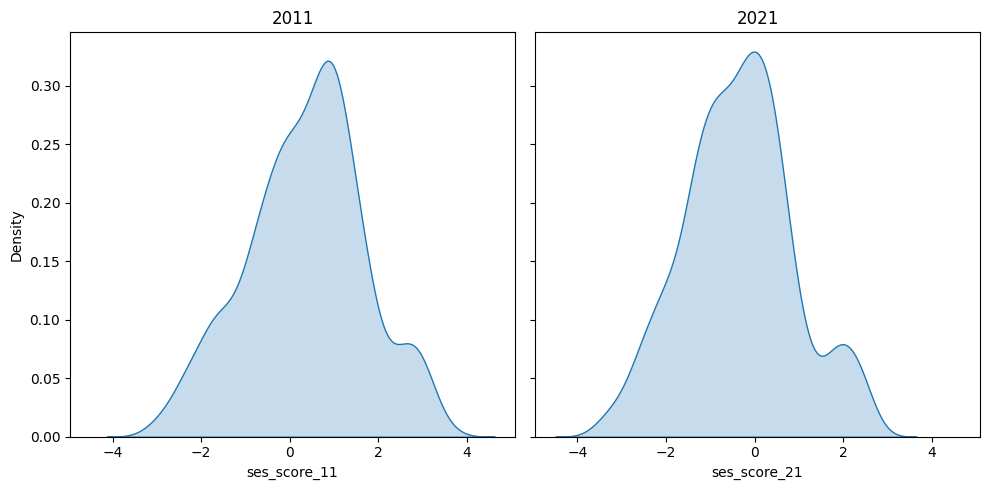

In [88]:
# look at the density of scores each year
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
#sns.kdeplot(scores_combined['ses_score_01'], shade=True, ax=axes[0])
#axes[0].set_title("2001")

sns.kdeplot(scores2_combined['ses_score_11'], shade=True, ax=axes[0])
axes[0].set_title("2011")

sns.kdeplot(scores2_combined['ses_score_21'], shade=True, ax=axes[1])
axes[1].set_title("2021")

plt.tight_layout()
plt.show()

## Creating SES diff and finishing processing data for modeling

In [89]:
scores2_combined['ses_diff_11_21'] = scores2_combined['ses_score_21'] - scores2_combined['ses_score_11']

dep_var = pd.DataFrame(scores2_combined['ses_diff_11_21'])
year = pd.DataFrame(['2011']*len(dep_var), index=dep_var.index)
dep_var = dep_var.merge(year, how='inner', on='msoa code')
dep_var.rename(columns={'ses_diff_11_21': 'y_var', 0: 'year'}, inplace=True)

#dep_df = pd.concat((dep_01_11, dep_11_21))

# drop 2021 rows in exp1
data_ready = exp2_processed[exp2_processed['year'] != '2021']

# combine dependent and ind vars
data_ready = data_ready.merge(dep_var, how='inner', on=['msoa code', 'year'])

### Splitting data and creating data loaders

In [91]:
# train valid test split
data_proc = data_ready.drop(['year', 'msoa name', 'city code', 'city name'], axis=1)
X_cities = data_proc.loc[:, data_proc.columns != 'y_var'].to_numpy()
y_cities = data_proc['y_var'].to_numpy()

X_c, X_test_c, y_c, y_test_c = train_test_split(X_cities, y_cities, test_size=0.2, random_state=186)
X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(X_c, y_c, test_size=0.2, random_state=186)

In [92]:
# init the pytorch dataset class

training_data_cities = CensusData(X_train_c, y_train_c)
training_loader_cities = torch.utils.data.DataLoader(training_data_cities, **dataset_params)

valid_data_cities = CensusData(X_valid_c, y_valid_c)
valid_loader_cities = torch.utils.data.DataLoader(valid_data_cities, **dataset_params)

### Optuna trial to find the best model

In [93]:
# running optuna trial using class objective

obj_cities = Objective(training_loader_cities, valid_loader_cities, define_model)
city_study = optuna.create_study(direction='minimize', sampler=cls_sampler)
city_study.optimize(obj_cities, n_trials=150, timeout=600, callbacks=[obj_cities.callback])

print("Best Trial:")
city_trial = city_study.best_trial

print("  Params: ")
for key, value in city_trial.params.items():
    print("    {}: {}".format(key, value))

best_city_model = obj_cities.best_booster
print("Best Model")
best_city_model

[I 2024-04-15 00:15:50,646] A new study created in memory with name: no-name-13c2f0a8-4d0c-4fde-bdf2-930d223a2c91
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([29])) that is different to the i

[I 2024-04-15 00:18:31,865] Trial 88 pruned. 
[I 2024-04-15 00:18:32,022] Trial 89 pruned. 
[I 2024-04-15 00:18:32,246] Trial 90 pruned. 
[I 2024-04-15 00:18:32,361] Trial 91 pruned. 
[I 2024-04-15 00:18:33,507] Trial 92 pruned. 
[I 2024-04-15 00:18:33,943] Trial 93 pruned. 
[I 2024-04-15 00:18:34,299] Trial 94 pruned. 
[I 2024-04-15 00:18:34,420] Trial 95 pruned. 
[I 2024-04-15 00:18:34,514] Trial 96 pruned. 
[I 2024-04-15 00:18:34,599] Trial 97 pruned. 
[I 2024-04-15 00:18:34,729] Trial 98 pruned. 
[I 2024-04-15 00:18:34,934] Trial 99 pruned. 
[I 2024-04-15 00:18:35,694] Trial 100 pruned. 
[I 2024-04-15 00:19:06,545] Trial 101 finished with value: 0.2600879967212677 and parameters: {'n_layers': 4, 'n_units_l0': 160, 'dropout_l0': 0.4, 'n_units_l1': 70, 'dropout_l1': 0.30000000000000004, 'n_units_l2': 105, 'dropout_l2': 0.5, 'n_units_l3': 30, 'dropout_l3': 0.4, 'lr': 0.0018666180193513122}. Best is trial 2 with value: 0.13992372155189514.
[I 2024-04-15 00:19:06,958] Trial 102 pruned. 

Best Trial:
  Params: 
    n_layers: 4
    n_units_l0: 155
    dropout_l0: 0.2
    n_units_l1: 75
    dropout_l1: 0.2
    n_units_l2: 85
    dropout_l2: 0.4
    n_units_l3: 45
    dropout_l3: 0.5
    lr: 0.0004270417081831423
Best Model


Sequential(
  (0): Linear(in_features=209, out_features=155, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=155, out_features=75, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=75, out_features=85, bias=True)
  (7): Tanh()
  (8): Dropout(p=0.4, inplace=False)
  (9): Linear(in_features=85, out_features=45, bias=True)
  (10): Tanh()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=45, out_features=1, bias=True)
)

### Calculating performance for city model

In [97]:
# sd train metrics
with torch.no_grad():
    y_train_city_pred = best_city_model(torch.from_numpy(X_train_c).float())

change_metrics(y_train_c, y_train_city_pred.numpy(), dataset='Train')

Train Accuracy: 0.7407912687585266
Train Balanced Accuracy: 0.5132341498752382
Train F1: 0.1810344827586207


In [98]:
# sd train metrics
with torch.no_grad():
    y_valid_city_pred = best_city_model(torch.from_numpy(X_valid_c).float())

change_metrics(y_valid_c, y_valid_city_pred.numpy(), dataset='Valid')

Valid Accuracy: 0.7717391304347826
Valid Balanced Accuracy: 0.5392930178206252
Valid F1: 0.19230769230769232


In [99]:
# sd train metrics
with torch.no_grad():
    y_test_city_pred = best_city_model(torch.from_numpy(X_test_c).float())

change_metrics(y_test_c, y_test_city_pred.numpy(), dataset='Valid')

Valid Accuracy: 0.7695652173913043
Valid Balanced Accuracy: 0.5288214101904272
Valid F1: 0.18461538461538463
